In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
%matplotlib inline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Missing data

In [3]:
df_null = df_train.isnull().sum()
#print (len(df_null))
df1 = pd.DataFrame()
for idx_num in range(len(df_null)):
    if df_null.values[idx_num] != 0:
        df_temp = pd.DataFrame(index = [df_null.index[idx_num]],data = [df_null.values[idx_num]])
        df1 = df1.append(df_temp)
print (df1)

                 0
LotFrontage    259
Alley         1369
MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
FireplaceQu    690
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
PoolQC        1453
Fence         1179
MiscFeature   1406


In [4]:
# handle the missing data

# Alley : NA means no alley, so change it to 'None'
df_train.loc[:,'Alley'] = df_train.loc[:,'Alley'].fillna('None')
# FireplaceQu : NA means no Fireplace
df_train.loc[:,'FireplaceQu'] = df_train.loc[:,'FireplaceQu'].fillna('None')
# PoolQC : NA means no pool
df_train.loc[:,'PoolQC'] = df_train.loc[:,'PoolQC'].fillna('None')
# Fence : NA means no fence
df_train.loc[:,'Fence'] = df_train.loc[:,'Fence'].fillna('None')
# MiscFeature : NA means no feature, and its MiscVal should be 0
df_train.loc[:,'MiscFeature'] = df_train.loc[:,'MiscFeature'].fillna('None')
## LotFrontage : make it 0 first
df_train.loc[:,'LotFrontage'] = df_train.loc[:,'LotFrontage'].fillna(0)
## MasVnrType : NaN most likely to be None, make it None first
df_train.loc[:,'MasVnrType'] = df_train.loc[:,'MasVnrType'].fillna('None')
## MasVnrArea : NaN is the same with MasVnrType, make it 0 first
df_train.loc[:,'MasVnrArea'] = df_train.loc[:,'MasVnrArea'].fillna(0)
# BsmtQual : NA means no basement 
df_train.loc[:,'BsmtQual'] = df_train.loc[:,'BsmtQual'].fillna('None')
# BsmtCond : NA means no basement
df_train.loc[:,'BsmtCond'] = df_train.loc[:,'BsmtCond'].fillna('None')
# BsmtExposure : NA means no basement, but index 948 is strange, based on other data with unfinished basement, the Nan is mostly 'No'
df_train.loc[948,'BsmtExposure'] = 'No'
df_train.loc[:,'BsmtExposure'] = df_train.loc[:,'BsmtExposure'].fillna('None')
# BsmtFinType1 : NA means no basement
df_train.loc[:,'BsmtFinType1'] = df_train.loc[:,'BsmtFinType1'].fillna('None')
# BsmtFinType2 : NA means no basement
df_train.loc[:,'BsmtFinType2'] = df_train.loc[:,'BsmtFinType2'].fillna('None')
# Electrical : only one NA, and hard to interpret, just drop the data
df_train = df_train[df_train['Electrical'].notnull()]
# GarageType, GarageYrBlt,GarageFinish,GarageQual,GarageCond : NA means no garage
df_train.loc[:,'GarageType'] = df_train.loc[:,'GarageType'].fillna('None')
df_train.loc[:,'GarageFinish'] = df_train.loc[:,'GarageFinish'].fillna('None')
df_train.loc[:,'GarageQual'] = df_train.loc[:,'GarageQual'].fillna('None')
df_train.loc[:,'GarageCond'] = df_train.loc[:,'GarageCond'].fillna('None')
## Tansfer GarageYrBlt later, fill in 0 first, then deal with it 
df_train.loc[:,'GarageYrBlt'] = df_train.loc[:,'GarageYrBlt'].fillna(0)


In [5]:
# handle categorical like feature value
# Survey the data, the features below are categorical type
# MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,
# Condition2,BldgType,HouseStyle,YearBuilt,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,
# ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating
# HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,
# GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def apply_label_encoder(feature_name):
    le.fit(df_train[feature_name])
    df_train[feature_name] = le.transform(df_train[feature_name])

labelEncoder_list = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
'Condition2','BldgType','HouseStyle','YearBuilt','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea',
'ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','Heating',
'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageYrBlt','GarageFinish',
'GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','YrSold','SaleType','SaleCondition']

for feature in labelEncoder_list:
    apply_label_encoder(feature)


In [6]:
# drop 'Id', it is no relationship with SalePrice
df_train = df_train.drop('Id',axis=1)

## Correlation

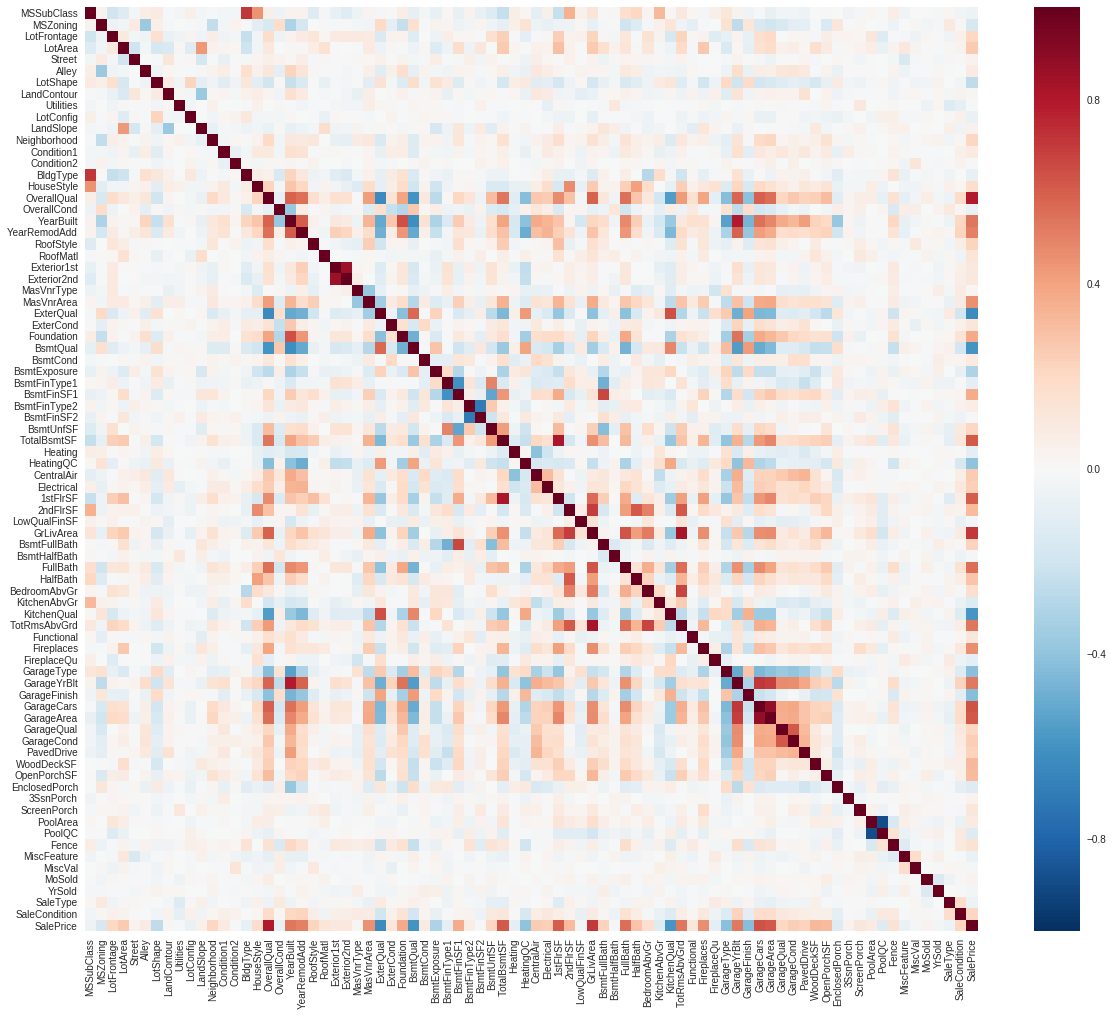

In [7]:
corrmat = df_train.corr()
f,ax = plt.subplots(figsize=(20,17))
sns.heatmap(corrmat)

In [8]:
corrmat.nlargest(len(df_train),'SalePrice')['SalePrice']

SalePrice        1.000000
OverallQual      0.791069
GrLivArea        0.708618
GarageCars       0.640473
GarageArea       0.623423
TotalBsmtSF      0.613905
1stFlrSF         0.605968
FullBath         0.560881
YearBuilt        0.535346
TotRmsAbvGrd     0.533779
GarageYrBlt      0.527901
YearRemodAdd     0.507430
Fireplaces       0.466968
MasVnrArea       0.458195
Foundation       0.382671
BsmtFinSF1       0.368806
WoodDeckSF       0.324422
2ndFlrSF         0.319464
OpenPorchSF      0.315831
HalfBath         0.284400
LotArea          0.263837
CentralAir       0.251367
GarageCond       0.246749
Electrical       0.234990
PavedDrive       0.231399
BsmtFullBath     0.227082
RoofStyle        0.222369
BsmtUnfSF        0.214446
SaleCondition    0.213121
Neighborhood     0.211292
                   ...   
MasVnrType       0.018262
LandContour      0.015490
Condition2       0.007509
BsmtFinSF2      -0.011412
Utilities       -0.014317
BsmtHalfBath    -0.016873
MiscVal         -0.021200
LowQualFinSF

In [9]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

In [10]:
from sklearn import linear_model
from sklearn.model_selection import KFold


def simple_linear_test(train_data,n_fold,feature_list):
    # use n-fold Cross validation 
    kf = KFold(n_fold).split(train_data)
    reg = linear_model.LinearRegression()
    part = 0
    total = 0
    y_train_data = train_data.loc[:,'SalePrice']
    X_train_data = train_data.drop('SalePrice',axis=1).loc[:,feature_list]
    for train_idx,test_idx in kf:
        print("TRAIN:", len(train_idx), "TEST:", len(test_idx))
        X_train, y_train = X_train_data.iloc[train_idx], y_train_data.iloc[train_idx]
        X_test, y_test = X_train_data.iloc[test_idx], y_train_data.iloc[test_idx]
        reg.fit(X_train,y_train)
        pred_test = reg.predict(X_test)
        part += 1
        pred_score = rmse(pred_test,y_test)
        total += pred_score
        print ("%d part RMSE: %.7f" % (part,pred_score))
    print ('Avg RMSE : ',total/n_fold)

In [11]:
simple_linear_test(df_train,10,['OverallQual'])

TRAIN: 1313 TEST: 146
1 part RMSE: 0.3784747
TRAIN: 1313 TEST: 146
2 part RMSE: 0.3949899
TRAIN: 1313 TEST: 146
3 part RMSE: 100.6995985
TRAIN: 1313 TEST: 146
4 part RMSE: 118.7578817
TRAIN: 1313 TEST: 146
5 part RMSE: 0.4538941
TRAIN: 1313 TEST: 146
6 part RMSE: 765.9801866
TRAIN: 1313 TEST: 146
7 part RMSE: 0.3900467
TRAIN: 1313 TEST: 146
8 part RMSE: 0.3746656
TRAIN: 1313 TEST: 146
9 part RMSE: 0.3797053
TRAIN: 1314 TEST: 145
10 part RMSE: 108.1347336
Avg RMSE :  109.594417677


In [12]:
# test Area code reference
# ----
# MasVnrType_dist = df_train['MasVnrType'].value_counts()
# print (MasVnrType_dist)
# df_train.loc[df_train['MasVnrType'].isnull()].loc[:,['MasVnrType','MasVnrArea']]
# ----
# df_train.loc[df_train['BsmtExposure'].isnull()].loc[948,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]
# ----
# m = df_train.loc[df_train['BsmtFinType1']=='Unf'].loc[:,['BsmtExposure','BsmtFinType1','BsmtFinType2']]
# m['BsmtExposure'].value_counts()
# ----
# df_train.loc[df_train['BsmtFinType2'].isnull()].loc[332,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]
# ----
# df_train.loc[df_train['GarageType'].isnull()].loc[:,['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']].count()
# ----
# df_train['GarageYrBlt'].describe()